In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import KFold, train_test_split
from PIL import Image
import matplotlib.pyplot as plt

In [4]:
# データへのパスを指定
folder_path = '../data/20250905_dataCollection/HSC_data/processed_images_'
csv_path = '../data/20250905_dataCollection/SugerContent_data/PeachSugerPrediction2025.csv'

# 画像を読み込む関数
def load_images_and_labels_from_folder(folder, csv_path, target_size=(128, 128)):
    df = pd.read_csv(csv_path)
    images = []
    labels = []
    for index, row in df.iterrows():
        filename = row['filename']
        label = row['label']
        img_path = os.path.join(folder, filename)
        if os.path.exists(img_path):
            img = Image.open(img_path).convert('RGB').resize(target_size)
            if img is not None:
                images.append(np.array(img))
                labels.append(label)
    return np.array(images), np.array(labels)

# 全波長のデータを読み込む
all_images = {}
all_labels = {}
test_images = {}
test_labels = {}

# 400nmから1700nmまでの波長を一度のforループで処理
for i in range(400, 1701, 5):
    folder_path_i = folder_path + str(i) + "nm"
    images, labels = load_images_and_labels_from_folder(folder_path_i, csv_path)
    
    # 各波長でトレーニングデータとテストデータを分割
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
    
    # トレーニングデータを保存
    if 'train_images' not in all_images:
        all_images['train_images'] = X_train
        all_labels['train_labels'] = y_train
    else:
        all_images['train_images'] = np.concatenate((all_images['train_images'], X_train), axis=0)
        all_labels['train_labels'] = np.concatenate((all_labels['train_labels'], y_train), axis=0)
    
    # テストデータを波長ごとに保存
    test_images[i] = X_test
    test_labels[i] = y_test

# データの正規化
X_train = all_images['train_images'].astype('float32') / 255.0
y_train = all_labels['train_labels']

# K分割交差検証
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
val_scores = []

for train_index, val_index in kf.split(X_train):
    print(f'Fold {fold}')
    fold += 1

    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # モデルを構築
    model = keras.Sequential([
        keras.layers.Input(shape=(128, 128, 3)),
        keras.layers.Conv2D(32, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(128, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    history = model.fit(X_train_fold, y_train_fold, epochs=20, 
                       validation_data=(X_val_fold, y_val_fold), batch_size=32)

    val_loss, val_mae = model.evaluate(X_val_fold, y_val_fold)
    val_scores.append(val_mae)
    print(f'Validation MAE for fold {fold-1}: {val_mae}')


Fold 1
Epoch 1/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 29s 121ms/step - loss: 7.5854 - mae: 1.8400 - val_loss: 3.5335 - val_mae: 1.3231
Epoch 2/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 27s 115ms/step - loss: 2.7515 - mae: 1.3402 - val_loss: 2.7774 - val_mae: 1.3595
Epoch 3/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 27s 115ms/step - loss: 2.5209 - mae: 1.2663 - val_loss: 2.0921 - val_mae: 1.1059
Epoch 4/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 27s 116ms/step - loss: 1.9667 - mae: 1.1011 - val_loss: 2.1412 - val_mae: 1.1314
Epoch 5/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 27s 115ms/step - loss: 1.6626 - mae: 1.0057 - val_loss: 1.5056 - val_mae: 0.9939
Epoch 6/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 27s 115ms/step - loss: 1.4132 - mae: 0.9106 - val_loss: 1.2285 - val_mae: 0.8330
Epoch 7/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 27s 116ms/step - loss: 1.2222 - mae: 0.8369 - val_loss: 1.0162 - val_mae: 0.7552
Epoch 8/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 27s 117ms/step - loss: 0.9930 - mae: 0.7340 - val_loss: 1.2468 - val_mae: 0.9215
Epoch 9/20
231/231 ━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 7.0562 - mae: 2.2451
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


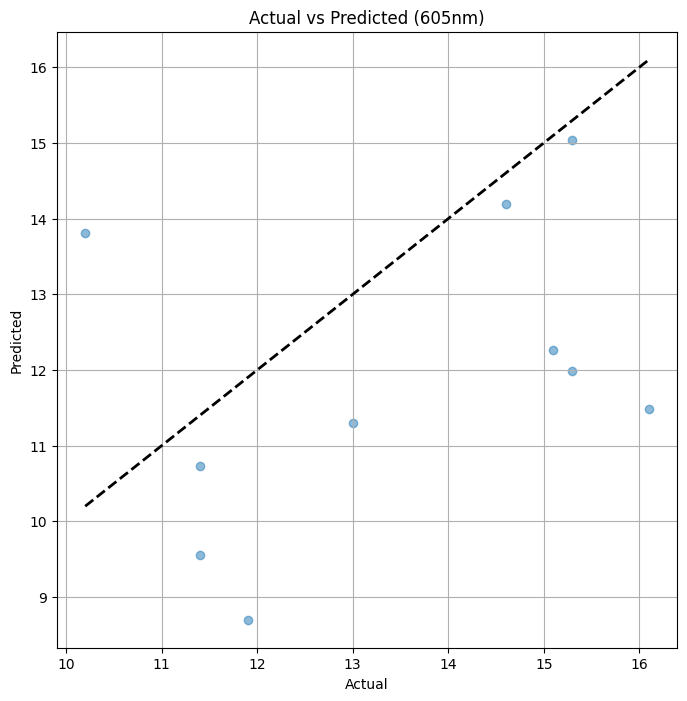

Correlation coefficient for 605nm: 0.3776525953898456

Test MAE for 605nm: 2.2450661659240723


(2.2450661659240723, np.float64(0.3776525953898456))

In [5]:
base_folder_path = '../data/20250905_dataCollection/HSC_data/processed_images_'
wavelength = 605

# 指定した波長でテスト
def test_wavelength(wavelength):
    X_test = test_images[wavelength].astype('float32') / 255.0
    y_test = test_labels[wavelength]
    
    test_loss, test_mae = model.evaluate(X_test, y_test)
    
    # 予測値を取得
    y_pred = model.predict(X_test)
    
    # 実際の値と予測値の相関図をプロット
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs Predicted ({wavelength}nm)')
    plt.grid(True)
    plt.show()
    
    # 相関係数を計算
    correlation_matrix = np.corrcoef(y_test, y_pred[:, 0])
    correlation_coefficient = correlation_matrix[0, 1]
    print(f'Correlation coefficient for {wavelength}nm:', correlation_coefficient)
    print(f'\nTest MAE for {wavelength}nm: {test_mae}')

    return test_mae, correlation_coefficient

test_wavelength(wavelength)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Wavelength 400 nm: Test MAE = 1.85, Correlation Coefficient = nan
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Wavelength 405 nm: Test MAE = 1.85, Correlation Coefficient = nan
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Wavelength 410 nm: Test MAE = 1.8559018135070802, Correlation Coefficient = 0.002625998177266229
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Wavelength 415 nm: Test MAE = 1.6008376121520995, Correlation Coefficient = 0.33906667328461004


d:\20250905桃の糖度分析\code\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
d:\20250905桃の糖度分析\code\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Wavelength 420 nm: Test MAE = 1.3928486824035646, Correlation Coefficient = 0.4249026134536142
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Wavelength 425 nm: Test MAE = 1.5344934082031254, Correlation Coefficient = 0.4141716513898961
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Wavelength 430 nm: Test MAE = 1.5957294082641604, Correlation Coefficient = 0.4400956062685958
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Wavelength 435 nm: Test MAE = 1.6043724632263185, Correlation Coefficient = 0.36108028067674786
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Wavelength 440 nm: Test MAE = 1.5927768135070806, Correlation Coefficient = 0.3632655441133397
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Wavelength 445 nm: Test MAE = 1.6862932777404787, Correlation Coefficient = 0.3548481822746961
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Wavelength 450 nm: Test MAE = 1.4380507850646977, Correlation Coefficient = 0.43656468701517864
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Wavelength 455 nm: Test MAE =

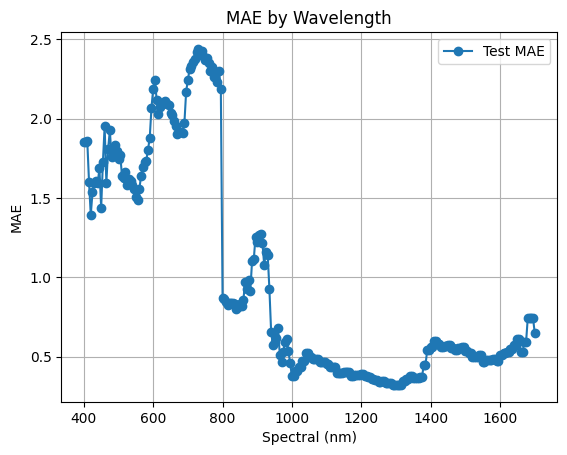

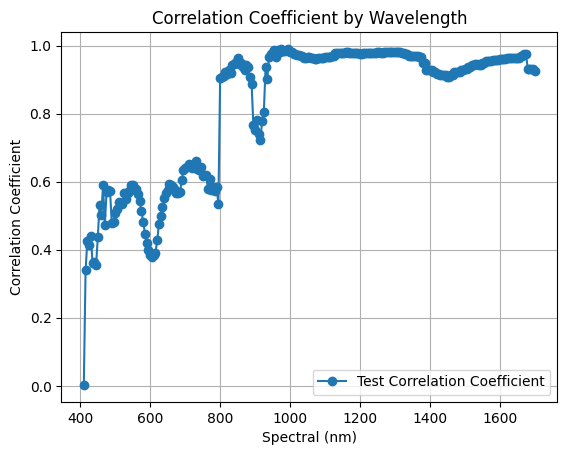


Top Wavelengths by Test MAE (Lowest to Highest):
   spectral       mae
0      1305  0.322413
1      1300  0.322413
2      1295  0.324638
3      1290  0.324638
4      1310  0.325005

Top Wavelengths by Test Correlation Coefficient (Highest to Lowest):
   spectral  correlation
0       995     0.990373
1       975     0.989802
2       955     0.988391
3       965     0.988322
4       990     0.987572


In [6]:
# 波長ごとのテストデータで評価する
test_mae_results = []
test_corr_results = []

for wavelength, X_test_wavelength in test_images.items():
    y_test_wavelength = test_labels[wavelength]
    
    # データの正規化
    X_test_wavelength = X_test_wavelength.astype('float32') / 255.0
    
    # モデルで予測
    y_pred = model.predict(X_test_wavelength).flatten()
    
    # MAEを計算
    mae = np.mean(np.abs(y_test_wavelength - y_pred))
    test_mae_results.append({'spectral': wavelength, 'mae': mae})
    
    # 相関係数を計算
    correlation_matrix = np.corrcoef(y_test_wavelength, y_pred)
    correlation_coefficient = correlation_matrix[0, 1]
    test_corr_results.append({'spectral': wavelength, 'correlation': correlation_coefficient})
    
    print(f"Wavelength {wavelength} nm: Test MAE = {mae}, Correlation Coefficient = {correlation_coefficient}")

# データフレーム化
df_test_mae = pd.DataFrame(test_mae_results)
df_test_corr = pd.DataFrame(test_corr_results)

# 波長ごとのMAEを折れ線グラフにプロット
plt.figure()
plt.plot(df_test_mae['spectral'], df_test_mae['mae'], marker='o', label='Test MAE')
plt.title('MAE by Wavelength')
plt.xlabel('Spectral (nm)')
plt.ylabel('MAE')
plt.legend()
plt.grid()
plt.show()

# 波長ごとの相関係数を折れ線グラフにプロット
plt.figure()
plt.plot(df_test_corr['spectral'], df_test_corr['correlation'], marker='o', label='Test Correlation Coefficient')
plt.title('Correlation Coefficient by Wavelength')
plt.xlabel('Spectral (nm)')
plt.ylabel('Correlation Coefficient')
plt.legend()
plt.grid()
plt.show()

# MAEと相関係数のトップを表示
df_test_mae_sorted = df_test_mae.sort_values(by='mae', ascending=True).reset_index(drop=True)
df_test_corr_sorted = df_test_corr.sort_values(by='correlation', ascending=False).reset_index(drop=True)

print("\nTop Wavelengths by Test MAE (Lowest to Highest):")
print(df_test_mae_sorted.head())

print("\nTop Wavelengths by Test Correlation Coefficient (Highest to Lowest):")
print(df_test_corr_sorted.head())



Top Wavelengths by Combined Score:
   spectral  combined_score  correlation       mae
0      1305        0.995217     0.980925  0.322413
1      1300        0.995217     0.980925  0.322413
2      1295        0.995003     0.981540  0.324638
3      1290        0.995003     0.981540  0.324638
4      1315        0.994475     0.980669  0.325005


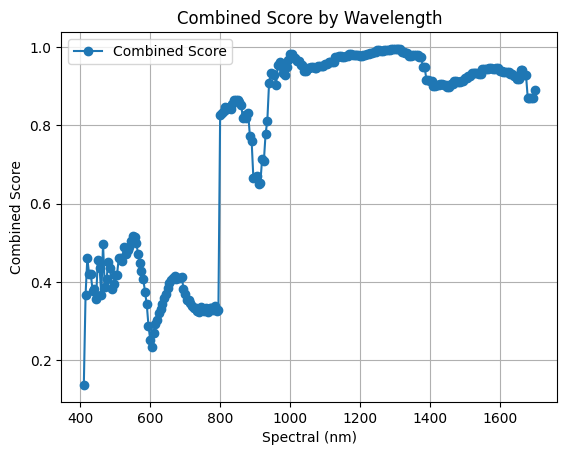

In [ ]:
# 相関係数とMAEの正規化
df_test_corr['normalized_corr'] = (df_test_corr['correlation'] - df_test_corr['correlation'].min()) / \
                                  (df_test_corr['correlation'].max() - df_test_corr['correlation'].min())

df_test_mae['normalized_mae'] = 1 - (df_test_mae['mae'] - df_test_mae['mae'].min()) / \
                                  (df_test_mae['mae'].max() - df_test_mae['mae'].min())

# 統一スコアを計算（重みは等しく設定）
combined_df = pd.merge(df_test_corr, df_test_mae, on='spectral')
combined_df['combined_score'] = 0.5 * combined_df['normalized_corr'] + 0.5 * combined_df['normalized_mae']

# 統一スコアでソート
combined_df_sorted = combined_df.sort_values(by='combined_score', ascending=False).reset_index(drop=True)

# 上位の波長を表示
print("\nTop Wavelengths by Combined Score:")
print(combined_df_sorted[['spectral', 'combined_score', 'correlation', 'mae']].head())

# 波長でソート
combined_df_sorted_for_plot = combined_df_sorted.sort_values(by='spectral')

# 折れ線グラフで正しい順序でプロット
plt.figure()
plt.plot(combined_df_sorted_for_plot['spectral'], combined_df_sorted_for_plot['combined_score'], marker='o', label='Combined Score')
plt.title('Combined Score by Wavelength')
plt.xlabel('Spectral (nm)')
plt.ylabel('Combined Score')
plt.legend()
plt.grid()
plt.show()

